### Pseudo-Voigt Functions

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os 
from zipfile import ZipFile, ZIP_DEFLATED
from scipy.special import voigt_profile

In [91]:
peak_densities_all = ['small', 'medium', 'large', 'very_large']
peak_density = peak_densities_all[3]

In [92]:
np.random.seed(42) # for reproducibility
num_repetitions = 2000
num_xs = 11837
x = np.linspace(0, 10, num_xs)

signals = np.zeros((num_repetitions, len(x)))
func_params = []

In [93]:
all_peaks = []

In [94]:
binary_peaks = np.zeros((num_repetitions, num_xs))

In [95]:
import math

In [96]:
for i in range(num_repetitions):
    if peak_density == 'small':
        n_func = np.random.randint(5, 20)
    elif peak_density == 'medium':
        n_func = np.random.randint(20,50)
    elif peak_density == 'large':
        n_func = np.random.randint(50, 100)
    else: n_func = np.random.randint(100, 200)
    
    signal = np.zeros(num_xs, )
    parameters = []
    peaks = []
    used_means = []

    for _ in range(n_func):

        attempts = 0

        while True:
            a = np.random.uniform(0,10) # peak center
            b = np.random.uniform(0.001,0.05) # half width half max (HWHM) for L
            # rule of thumb is 7 points per peak, maybe 5
            stddev = b / np.sqrt(2 * np.log(2)) # convert b to std dev
            mix_param = np.random.uniform(0.2,0.8)

            min_d = b * 4
            if all(abs(a - m) >= min_d for m in used_means):
                used_means.append(a)
                break
            attempts += 1
            if attempts > 500: # avoid inf loop
                break

        lor = (1 / math.pi) * (b / ((x - a)**2 + b**2))
        gau = np.exp(-((x - a)**2) / (2 * stddev ** 2))

        amp = np.random.uniform(0.01, 1.00)
        pseudo_V = (mix_param * lor + (1 - mix_param) * gau) * amp

        signal += pseudo_V
        parameters.append((a, b, stddev, mix_param))

        peak_index = np.argmax(pseudo_V)
        peaks.append(peak_index)

        trim_min, trim_max = (a - (2*b) / 4, a + (2*b) / 4)

        # Create a boolean mask where x_values are between trim_min and trim_max
        trim_mask = (x >= trim_min) & (x <= trim_max)

        add_ones = np.where(trim_mask == True)[0]
        binary_peaks[i][add_ones] = 1

    signals[i] = signal
    func_params.append(parameters)
    all_peaks.append(peaks)

In [97]:
plt.close('all')

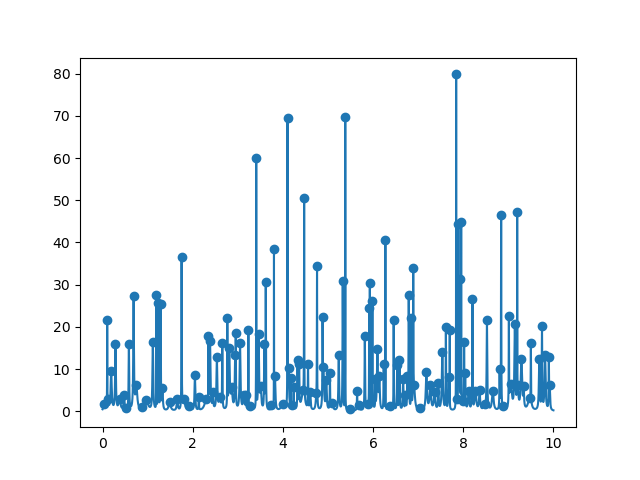

In [98]:
plt.figure()
i=15
plt.plot(x, signals[i])
plt.scatter(x[all_peaks[i]], signals[i][all_peaks[i]])
plt.show()

In [99]:
all_peaks[0]

[np.int64(11253),
 np.int64(1846),
 np.int64(8381),
 np.int64(2513),
 np.int64(6211),
 np.int64(1651),
 np.int64(9293),
 np.int64(550),
 np.int64(3605),
 np.int64(1444),
 np.int64(3063),
 np.int64(6471),
 np.int64(10911),
 np.int64(3851),
 np.int64(4223),
 np.int64(9495),
 np.int64(2352),
 np.int64(8629),
 np.int64(3917),
 np.int64(5589),
 np.int64(1277),
 np.int64(4857),
 np.int64(3429),
 np.int64(7497),
 np.int64(10564),
 np.int64(3764),
 np.int64(6045),
 np.int64(11502),
 np.int64(7215),
 np.int64(10750),
 np.int64(11666),
 np.int64(2813),
 np.int64(9887),
 np.int64(6994),
 np.int64(8178),
 np.int64(4037),
 np.int64(109),
 np.int64(7717),
 np.int64(10051),
 np.int64(4352),
 np.int64(5829),
 np.int64(288),
 np.int64(11080),
 np.int64(6845),
 np.int64(3206),
 np.int64(7814),
 np.int64(2932),
 np.int64(1374),
 np.int64(5135),
 np.int64(1928),
 np.int64(4594),
 np.int64(1193),
 np.int64(843),
 np.int64(9640),
 np.int64(8884),
 np.int64(4153),
 np.int64(7317),
 np.int64(963),
 np.int64(6

In [100]:
np.argmax(signals[0], axis=0)

np.int64(11423)

(2000, 11837)


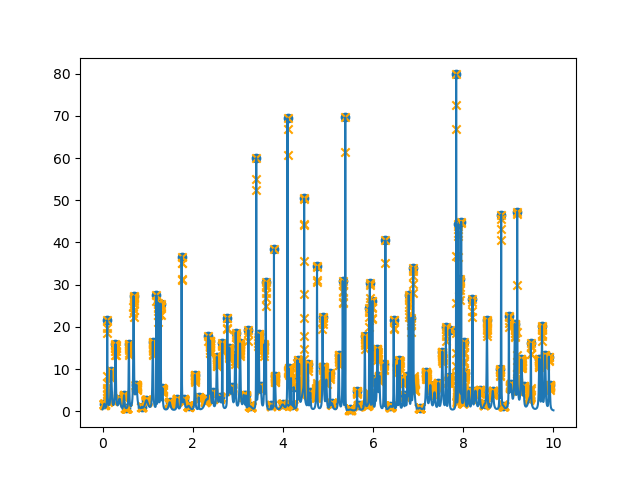

In [101]:
plt.figure()
i=15

print(binary_peaks.shape)

all_ones = np.where(binary_peaks[i] > 0)[0]
all_ones.shape

plt.plot(x, signals[i])
plt.scatter(x[all_peaks[i]], signals[i][all_peaks[i]])

plt.scatter(x[all_ones], signals[i][all_ones], marker='x', color='orange')

plt.show()


In [102]:
def add_noise_by_percentage(signal, noise_percentage):
        """
        Add random noise to a NumPy array based on a percentage of the maximum signal value.

        Parameters:
            signal (numpy.ndarray): The original signal array.
            noise_percentage (float): Percentage of the maximum signal value to use as noise.

        Returns:
            noisy_signal (numpy.ndarray): The signal array with added noise.
        """
        # Find the maximum value in the signal
        max_value = np.max(np.abs(signal))

        # Calculate the noise standard deviation as a percentage of the max signal value
        noise_std = (noise_percentage / 100) * max_value

        # Generate random Gaussian noise with zero mean and calculated standard deviation
        noise = np.random.normal(0.005, noise_std, signal.shape)

        # Add the noise to the original signal
        noisy_signal = signal + noise

        return noisy_signal

noisy_signal = add_noise_by_percentage(signals, 0.05)

In [103]:
ds = xr.Dataset(
    {
        "Intensities": (["pattern", "x"], noisy_signal),
        "BinaryArr": (["pattern", "x"], binary_peaks)
    },
    coords = {
        "pattern": np.arange(num_repetitions),
        "x": np.linspace(1, 10, x.shape[0])
    },
    attrs={
        "description": "Simulated pseudo-Voigt signals with labeled peaks, padded with 1s along FWHM",
        "min_d_rule": "Minimum distance between peaks = 4 * b",
        "note": f"Each pattern contains a {peak_density} number of peaks. Used_means enforces peak spacing.",
        "mixing": "The mixing parameter is np.random.uniform(0.2,0.8) with a seed=42",
        "params": "a=np.random.uniform(1,8) b=np.random.uniform(0.05,0.1), seed=42",
        "noise": "True, 0.2%",
        "number": f"num_repetitions"
    }
)

In [104]:
intensities = ds["Intensities"].values
binary = ds["BinaryArr"].values

(2000, 11837)


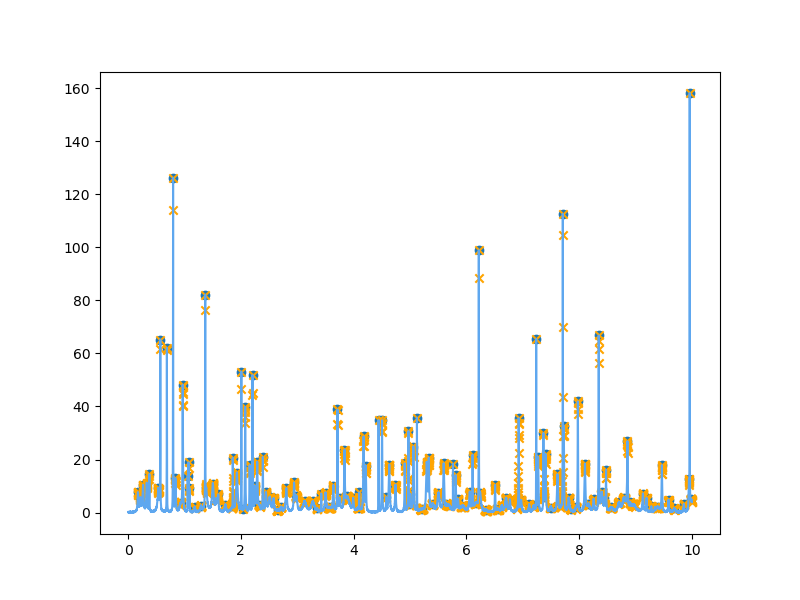

In [105]:
# Check that there is noise
plt.figure(figsize=(8,6))

i=np.random.randint(0,2000)

print(binary_peaks.shape)

all_ones = np.where(binary_peaks[i] > 0)[0]
all_ones.shape

plt.plot(x, intensities[i], color='#5EA7EF')
plt.scatter(x[all_peaks[i]], intensities[i][all_peaks[i]])

plt.scatter(x[all_ones], intensities[i][all_ones], marker='x', color='orange')

plt.show()


In [106]:
%matplotlib widget

In [107]:
plt.close('all')

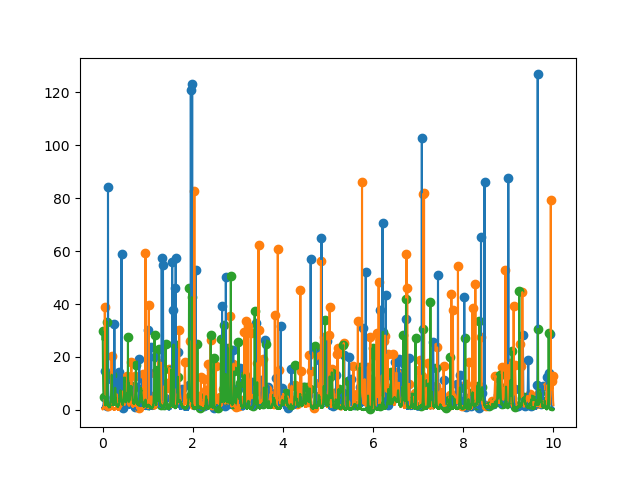

In [108]:
plt.figure()
for i in range(3):
    plt.plot(x, intensities[i])
    plt.scatter(x[all_peaks[i]], intensities[i][all_peaks[i]])
plt.show()

In [109]:
path = '../saved_data/'
file = f'psuedovoigt_functions_{peak_density}_var_amps_noisy_11763.nc'

ds.to_netcdf(os.path.join(path, file))
with ZipFile(os.path.join(path,file.replace('.nc','.zip')), 'w', ZIP_DEFLATED) as zObject:
    zObject.write(os.path.join(path,file), arcname=file)
